In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow
import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.layers as layers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score # k-folding
from sklearn.model_selection import KFold
import sklearn.metrics
from scipy import stats
import json

2023-05-08 15:29:02.719393: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import cactas as C

In [4]:
asymp_img = np.load('/raid/mpsych/CACTAS/DATA/ESUS/asymp_cropped_no_norm.npy')
symp_img = np.load('/raid/mpsych/CACTAS/DATA/ESUS/symp_cropped_no_norm.npy')
asymp_label = np.load('/raid/mpsych/CACTAS/DATA/ESUS/asymp_cropped_labels_no_norm.npy')
symp_label = np.load('/raid/mpsych/CACTAS/DATA/ESUS/symp_cropped_labels_no_norm.npy')

In [5]:
images = np.concatenate((asymp_img, symp_img, asymp_label, symp_label))
labels = np.array([0]*len(asymp_img) + [0]*len(asymp_label) + [1]*len(symp_img) + [1]*len(symp_label))

In [6]:
train_f1 = []
test_f1 = []
train_acc = []
test_acc = []
confusion_matrices = []  # Store confusion matrices for each iteration
for i in range(10):
    X, y = shuffle(images, labels, random_state=0)
    #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    X_train, X_val, y_train, y_val = C.Util.split_3(X, y, val_size=0.10)
    
    X_train_raveled = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
    X_val_raveled = X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2])
    
    # t~20
    #rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=1) # Tweak THis
    # Comments below are to reduce overfitting, do the opposite if focusing on decreasing false positives
    rf = RandomForestClassifier(n_estimators=100, max_depth=5,          #5 Reduce max_depth
                             min_samples_split=10, # Increase min_samples_split
                             min_samples_leaf=1,   # Increase min_samples_leaf
                             #max_features='sqrt', # Lower threshold of max # of features used by each tree
                             random_state=42)

    # 5-fold cross-validation on the training data
    scores = cross_val_score(rf, X_train_raveled, y_train, cv=10, scoring='f1')
    scores_acc = cross_val_score(rf, X_train_raveled, y_train, cv=10, scoring='accuracy')
    k = 10
    kf = KFold(n_splits=k)
    fitted = rf.fit(X_train_raveled, y_train)
    y_pred = rf.predict(X_val_raveled)
    
    # Training acc, f1
    train_accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)
    f1 = sklearn.metrics.f1_score(y_val, y_pred)
    print('run', i, 'acc', train_accuracy, 'f1', f1)
    train_acc.append(train_accuracy)
    train_f1.append(f1)
    
    asymp_img_test = np.load('/raid/mpsych/CACTAS/DATA/ESUS/asymp_cropped.npy')
    symp_img_test = np.load('/raid/mpsych/CACTAS/DATA/ESUS/symp_cropped.npy')
    asymp_label_test = np.load('/raid/mpsych/CACTAS/DATA/ESUS/asymp_labels_cropped.npy')
    symp_label_test = np.load('/raid/mpsych/CACTAS/DATA/ESUS/symp_labels_cropped.npy')
    
    labels_test = np.array([0]*len(asymp_img_test) + [0]*len(asymp_label_test) + [1]*len(symp_img_test) + [1]*len(symp_label_test))
    images_test = np.concatenate((asymp_img_test, symp_img_test, asymp_label_test, symp_label_test))
    
    X_test, y_test = shuffle(images_test, labels_test, random_state=0)
    
    X_test_raveled = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
    
    y_pred = rf.predict(X_test_raveled)
    
    # Calculate the confusion matrix for the current iteration
    cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    
    # Testing acc, f1
    c_test_acc = sklearn.metrics.accuracy_score(y_test, y_pred)
    c_test_f1 = sklearn.metrics.f1_score(y_test, y_pred)
    print('test run', i, 'acc', c_test_acc, 'f1', c_test_f1)
    
    
    test_acc.append(c_test_acc) # acc test
    test_f1.append(c_test_f1) # f1 test

# Calculate the average confusion matrix
avg_conf_matrix = np.mean(confusion_matrices, axis=0)

# Extract the counts of TP, TN, FP, and FN
tn, fp, fn, tp = avg_conf_matrix.ravel()

# Total samples for percentage
total_samples = tp + tn + fp + fn
print(total_samples)
tp_perc = (tp / total_samples) * 100
tn_perc = (tn / total_samples) * 100
fp_perc = (fp / total_samples) * 100
fn_perc = (fn / total_samples) * 100


# Print the mean and standard deviation of the cross-validation scores
print('Test F1 score:', test_f1)
print('Train F1 score:', train_f1)
print('Test acc score:', test_acc)
print('Train acc score:', train_acc)
print("Cross-validation F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Cross-validation acc score: %0.2f (+/- %0.2f)" % (scores_acc.mean(), scores_acc.std() * 2))

print(f"True Positives: {tp_perc:.2f}%")
print(f"True Negatives: {tn_perc:.2f}%")
print(f"False Positives: {fp_perc:.2f}%")
print(f"False Negatives: {fn_perc:.2f}%")



run 0 acc 1.0 f1 1.0
test run 0 acc 0.8687367678193366 f1 0.8833124215809285
run 1 acc 0.9963768115942029 f1 0.9965870307167235
test run 1 acc 0.8652081863091038 f1 0.8803258145363408
run 2 acc 1.0 f1 1.0
test run 2 acc 0.8782639378969654 f1 0.8908573236317622
run 3 acc 1.0 f1 1.0
test run 3 acc 0.8712067748764997 f1 0.8852562087393901
run 4 acc 0.9963768115942029 f1 0.9965870307167235
test run 4 acc 0.8708539167254764 f1 0.8847607052896725
run 5 acc 0.9963768115942029 f1 0.9965870307167235
test run 5 acc 0.8867325335215244 f1 0.8974768444586393
run 6 acc 0.9963768115942029 f1 0.9965870307167235
test run 6 acc 0.8546224417784051 f1 0.8721291123525761
run 7 acc 0.9963768115942029 f1 0.9965870307167235
test run 7 acc 0.8913196894848271 f1 0.9012187299550996
run 8 acc 1.0 f1 1.0
test run 8 acc 0.8793225123500353 f1 0.8917036098796707
run 9 acc 0.9963768115942029 f1 0.9965870307167235
test run 9 acc 0.8757939308398024 f1 0.8886780518659078
2834.0
Test F1 score: [0.8833124215809285, 0.88032

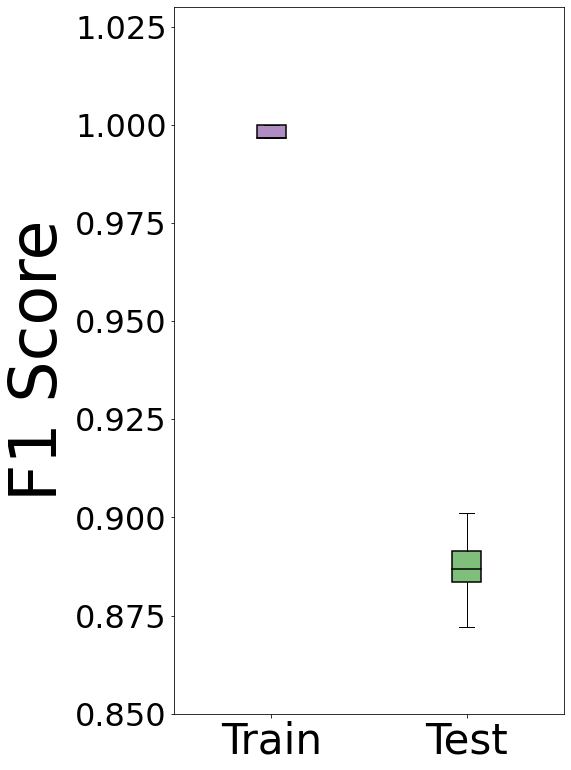

Train 0.9979522184300341 +/- 0.0016720066503639688
Test 0.8875718822289989 +/- 0.007973871973237281
t_20 = 40.644 ,p= 0.0


In [7]:
#f1 boxplot
data = [train_f1, test_f1]
labels = ['Train', 'Test']
C.Util.boxplot(data, labels, y_lim=1, y_label='F1 Score', outputdir='/home/jiehyun.kim001/CACTAS/_EXPERIMENTS/', y_zoom=(0.85, 1.03))

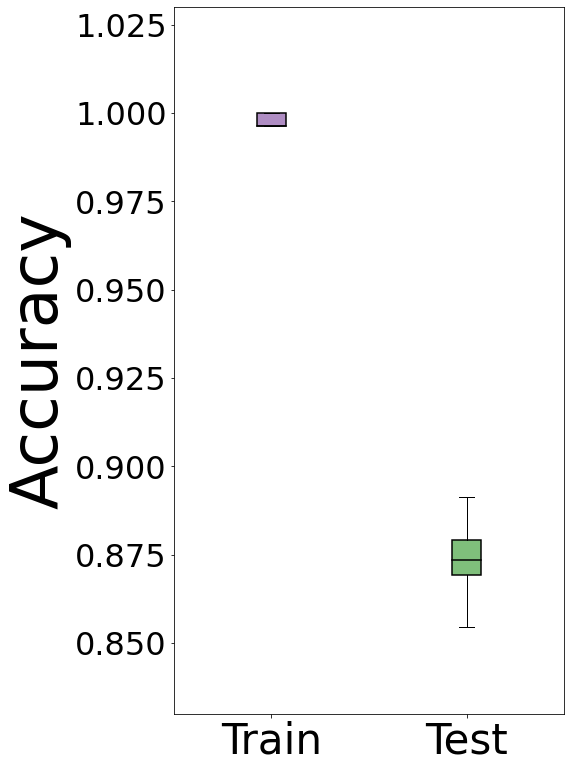

Train 0.9978260869565219 +/- 0.001774992567234195
Test 0.8742060691601976 +/- 0.010047786875020137
t_20 = 36.347 ,p= 0.0


In [8]:
# acc boxplot
data = [train_acc, test_acc]
labels = ['Train', 'Test']
C.Util.boxplot(data, labels, y_lim=1, y_label='Accuracy', outputdir='/home/jiehyun.kim001/CACTAS/_EXPERIMENTS/', y_zoom=(0.83,1.03))

In [9]:
#NOTES
# Some overfitting
# f1 variance of testing
# Identifies all pos cases, no false neg (great, most important), but false positives incorrectly idnetifying neg cases (asymp, ok)